# Ideal plastic Von Mises material

Author(s): Olli Väinölä <olli.vainola@student.oulu.fi>

In this notebook is an small tutorial, how to create a Von Mises material without any hardening. Equations are formulated into rate depended form.

In [1]:
# imports
using PyPlot
using ForwardDiff
using NLsolve

Let's create a isotropic Hooke material.

In [2]:


"""
Create a isotropic Hooke material matrix C 

More information: # http://www.efunda.com/formulae/solid_mechanics/mat_mechanics/hooke_isotropic.cfm

Parameters
----------
    E: Float
        Elastic modulus
    ν: Float
        Poisson constant

Returns
-------
    Array{Float64, (6,6)}
"""
function hookeStiffnessTensor(E, ν)
    a = 1 - ν
    b = 1 - 2*ν
    c = 1 + ν
    multiplier = E / (b * c)
    return Float64[a ν ν 0 0 0;
                   ν a ν 0 0 0;
                   ν ν a 0 0 0;
                   0 0 0 b 0 0;
                   0 0 0 0 b 0;
                   0 0 0 0 0 b].*multiplier
end

# Pick material values
E = 200.0e3
ν =  0.3
C = hookeStiffnessTensor(E, ν)

6x6 Array{Float64,2}:
 2.69231e5  1.15385e5  1.15385e5  0.0        0.0        0.0      
 1.15385e5  2.69231e5  1.15385e5  0.0        0.0        0.0      
 1.15385e5  1.15385e5  2.69231e5  0.0        0.0        0.0      
 0.0        0.0        0.0        1.53846e5  0.0        0.0      
 0.0        0.0        0.0        0.0        1.53846e5  0.0      
 0.0        0.0        0.0        0.0        0.0        1.53846e5

# Defining equations for the calculation

Functions are defined for strain controller simulation

In [3]:

"""
Equivalent tensile stress. 

More info can be found from: https://en.wikipedia.org/wiki/Von_Mises_yield_criterion
    Section: Reduced von Mises equation for different stress conditions

Parameters
----------
    σ: Array{Float64, 6}
        Stress in Voigt notation

Returns
-------
    Float
"""
function σₑ(σ)
    e1 = (σ[1] - σ[2])^2
    e2 = (σ[2] - σ[3])^2
    e3 = (σ[3] - σ[1])^2
    e4 = σ[4]^2 
    e5 = σ[5]^2
    e6 = σ[6]^2
    return sqrt((e1 + e2 + e3 + 6 * (e4 + e5 + e6)) / 2.)
end


"""
Von Mises Yield criterion

More info can be found from: http://csm.mech.utah.edu/content/wp-content/uploads/2011/10/9tutorialOnJ2Plasticity.pdf

Parameters
----------
    σ: Array{Float64, 6}
        Stress in Voigt notation
    k: Float64
        Material constant, Yield limit

Returns
-------
    Float
"""
function vonMisesYield(σ, k)
    σₑ(σ) - k
end

"""
Function for NLsolve. Inside this function are the equations which we want to find root.
Ψ is the yield function below. Functions defined here:

    dσ - C (dϵ - dλ*dΨ/dσ) = 0
                 σₑ(σ) - k = 0

Parameters
----------
    params: Array{Float64, 7}
        Array containing values from solver
    dϵ: Array{Float64, 6}
        Strain rate vector in Voigt notation
    C: Array{Float64, (6, 6)}
        Material tensor
    k: Float
        Material constant, yield limit
    Δt: Float
        time increment
    σ_begin:Array{Float64, 6}
        Stress vector in Voigt notation

Returns
-------
    Array{Float64, 7}, return values for solver
"""
function G(params, dϵ, C, k, Δt, σ_begin)
    # Creating wrapper for gradient
    yield(pars) = vonMisesYield(pars, k)
    dfdσ = ForwardDiff.gradient(yield)
    
    # Stress rate
    dσ = (σ_begin - params[1:6]) / Δt
    
    # Calculating plastic strain rate
    dϵp = params[end] * dfdσ(params)
    
    # Calculating equations
    function_1 = dσ - C * (dϵ - dϵp[1:6])
    function_2 = yield(params)
    [function_1[:]; function_2]
end

"""
Function which calculates the stress. Also handles if any yielding happens

Parameters
----------
    dϵ: Array{Float64, 6}
        Strain rate vector in Voigt notation
    Δt: Float
        time increment
    σ: Array{Float64, 6}
        Last stress vector in Voigt notation
    C: Array{Float64, (6, 6)}
        Material tensor
    k: Float
        Material constant, yield limit

Returns
-------
    Tuple
    Plastic strain rate dϵᵖ and new stress vector σ
"""
function calculate_stress(dϵ, Δt, σ, C, k)

    # Test stress
    σ_tria = σ + Δt * C * dϵ
    
    # Calculating yield
    yield = vonMisesYield(σ_tria, k)
    
    if yield > 1
        
        # Yielding happened
        # Creating functions for newton: xₙ₊₁ = xₙ - df⁻¹ * f and initial values
        initial_guess = [σ[:]; 0.0]
        f(σ_)  = G(σ_, dϵ, C, k, Δt, σ_tria)
        df     = ForwardDiff.jacobian(f)
        
        # Calculating root 
        result = nlsolve(not_in_place(f, df), initial_guess).zero
        
        σ      = result[1:6]        
        dλ     = result[end]
        
        # these are not necessary to calculate for our calculation but why not?
        yield_f(σ_) = vonMisesYield(σ_, k)
        dfdσ_ = ForwardDiff.gradient(yield_f)
        dϵᵖ    = dλ * dfdσ_(σ)
    else
        dϵᵖ = zeros(Float64, (6, 1))
        σ = σ_tria
    end
    return (dϵᵖ, σ)
end

calculate_stress (generic function with 1 method)

# Defining strain history

In [4]:
steps = 200

ϵ_tot = zeros(Float64, (steps, 6))

# Adding only strain in x-axis and counting for the poisson effect
ϵ_tot[:, 1] = linspace(0, 0.002, steps)
ϵ_tot[:, 2] = linspace(0, 0.002, steps).*-ν
ϵ_tot[:, 3] = linspace(0, 0.002, steps).*-ν

linspace(-0.0,-0.0006,200)

# Simulation

Ok, we're good to go! Now we just need to define yield limit and the main loop.

This simulation is not time dependent, but since it's already defined in the equations we'll give it value 1

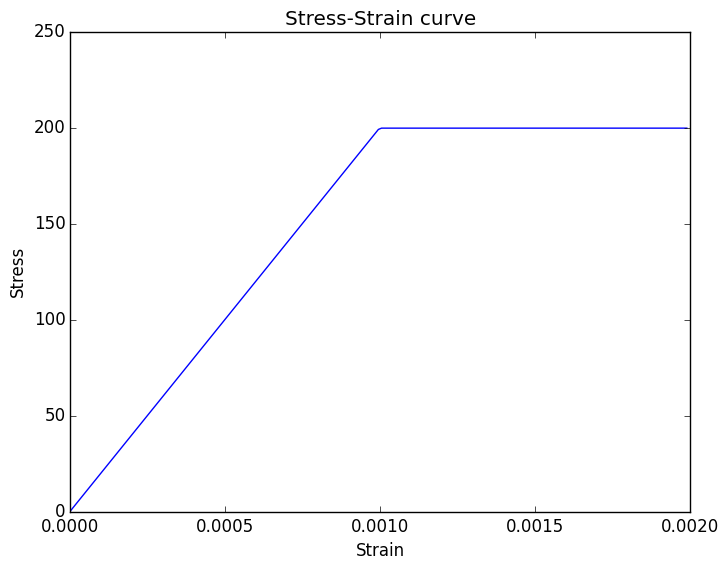

(0,250)

In [11]:
ϵ_last = zeros(Float64, (6))
ϵᵖ = zeros(Float64, (6))
σ = zeros(Float64, (6, 1))
Δt = 1.0
σy =  200.0
ss = zeros(Float64, steps)
ee = zeros(Float64, steps)
for i=1:steps
    ss[i] = σ[1]
    ee[i] = ϵ_last[1]
    dϵ = (reshape(ϵ_tot[i, :, :], (6, 1)) - ϵ_last) / Δt 
    dϵᵖ, σ = calculate_stress(dϵ, Δt, σ, C, σy)
    ϵ_last += dϵ * Δt
end
PyPlot.plot(ee, ss)
PyPlot.title("Stress-Strain curve")
PyPlot.xlabel("Strain")
PyPlot.ylabel("Stress")
PyPlot.ylim([0, 250])